In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

sns.set(context='talk')


# a function to get predictions so we can plot true mullen vs predicted mullen
def get_held_outpredictions(X, estimators, splits):
    y_est = np.zeros(len(X))
    for i, (train_inds, test_inds) in enumerate(splits):
        estimator = estimators[i]
        y_est[test_inds] = estimator.predict(pd.DataFrame(X[test_inds, :]))
    return y_est

# function to scatter plot the true mullens vs estimates
def plot_scatter(y_true, y_est, months, model):
    plt.figure(figsize=(12, 12))
    straight_line = np.linspace(y_true.min() * 0.95, y_true.max() * 1.05, 100)
    plt.plot(straight_line, straight_line, alpha=0.25, c='r')
    plt.scatter(y_true, y_est, alpha=0.75)
    plt.xlabel('Average Raw Mullen Score')
    plt.ylabel('Predicted Average Raw Mullen Score')
    plt.xlim(y_true.min() * 0.95, y_true.max() * 1.05)
    plt.ylim(y_true.min() * 0.95, y_true.max() * 1.05)
    plt.title(f'Model = {model}, Months = {months}, R^2 = {np.round(r2_score(y_true, y_est), 3)}')

# load data
with open('data/processed_data.pickle', 'rb') as f:
    df_6m, input_covariates_6m, df_24m, input_covariates_24m = pickle.load(f)
    X_6m = df_6m[input_covariates_6m].values
    y_6m_raw = df_6m['mullen_6m_raw_average'].values
    X_24m = df_24m[input_covariates_24m].values
    y_24m_raw = df_24m['mullen_24m_raw_average'].values
    
# load results and models
with open('data/ml_results.pickle', 'rb') as f:
    raw_6m_results, raw_6m_outer_cv, raw_24m_results, raw_24m_outer_cv = pickle.load(f)

C:\miniconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


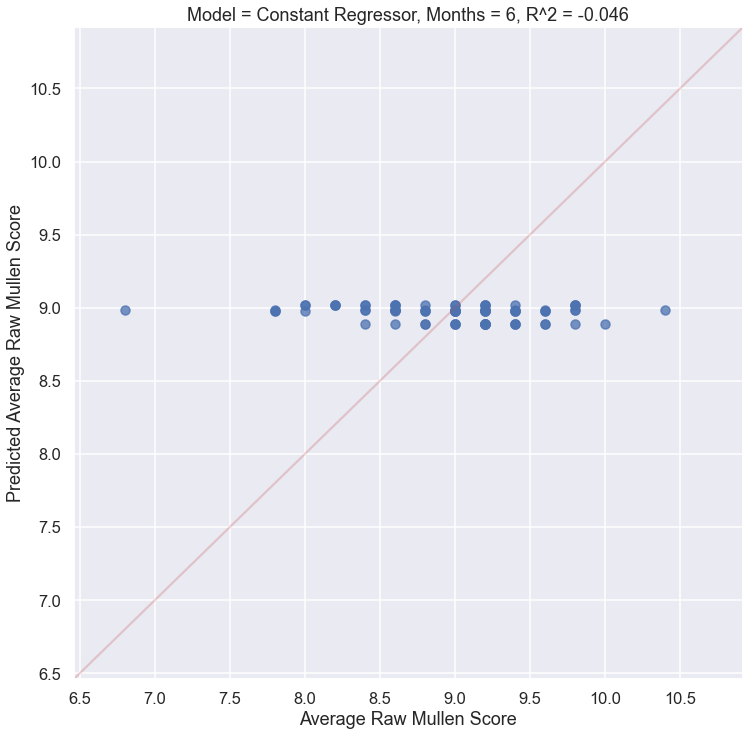

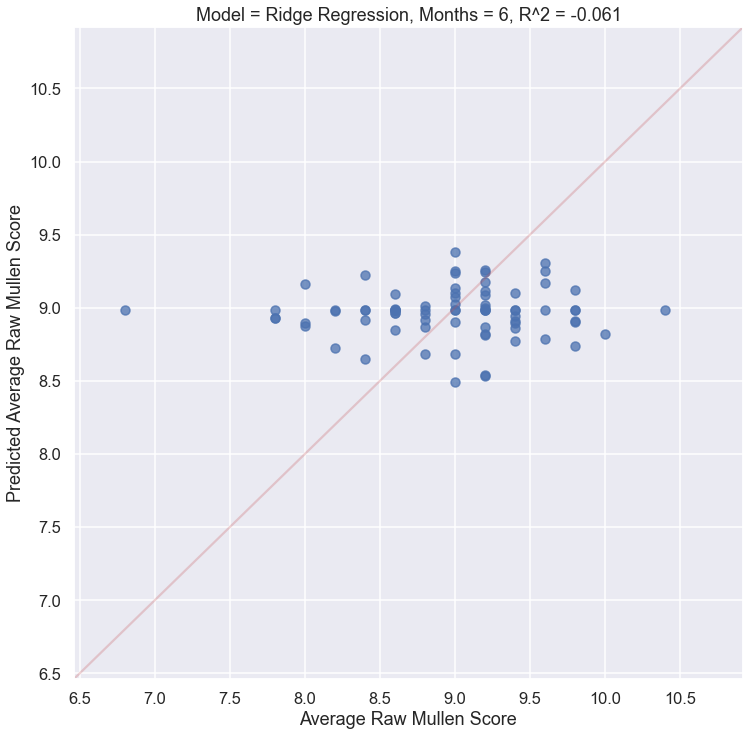

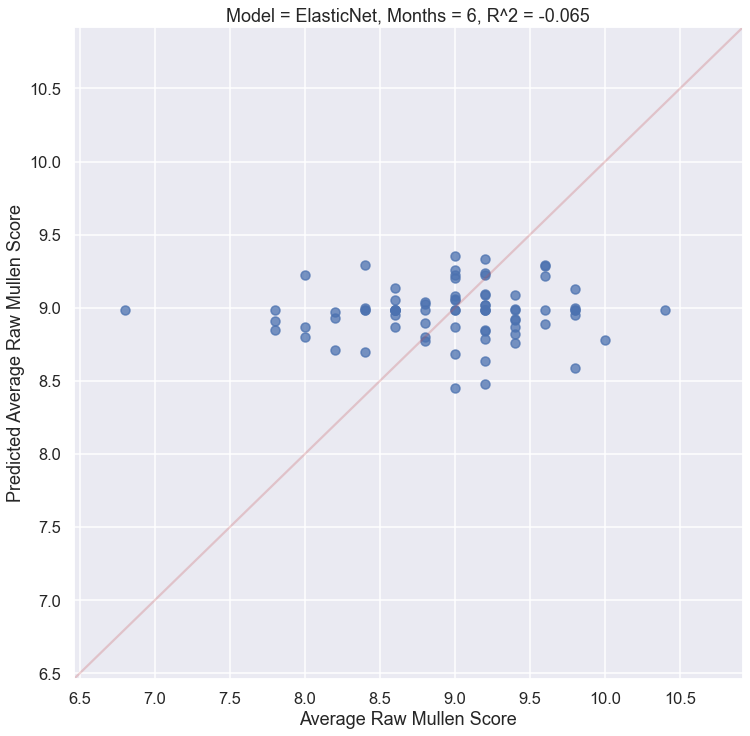

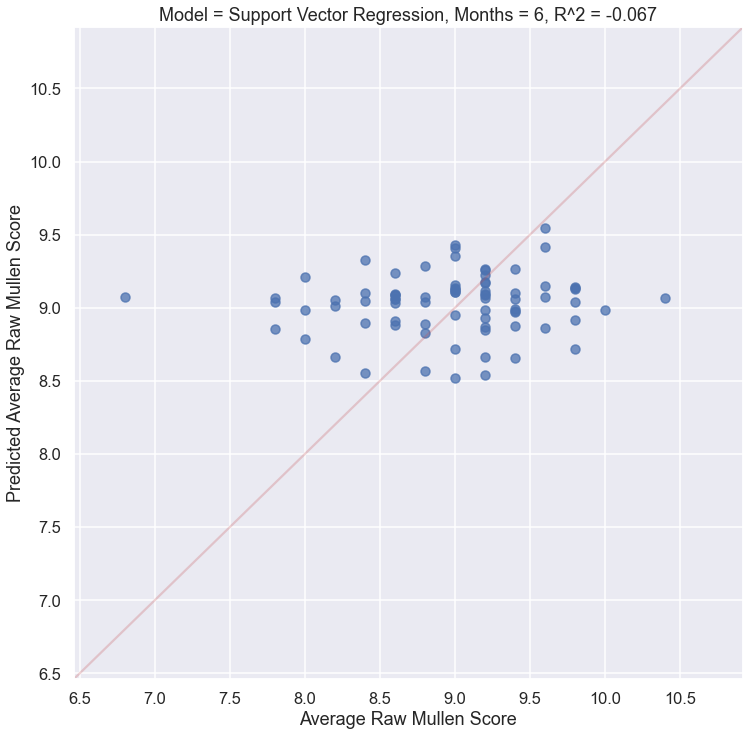

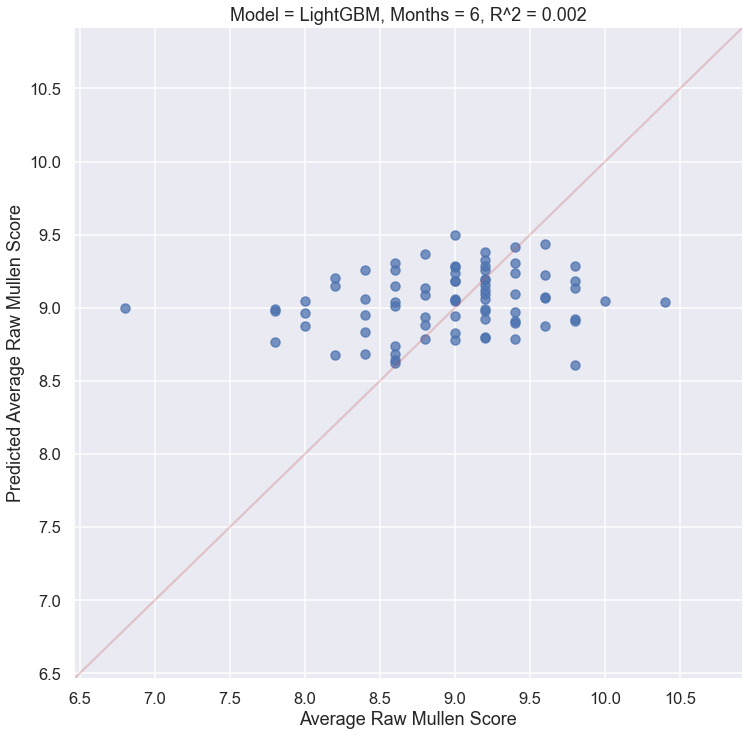

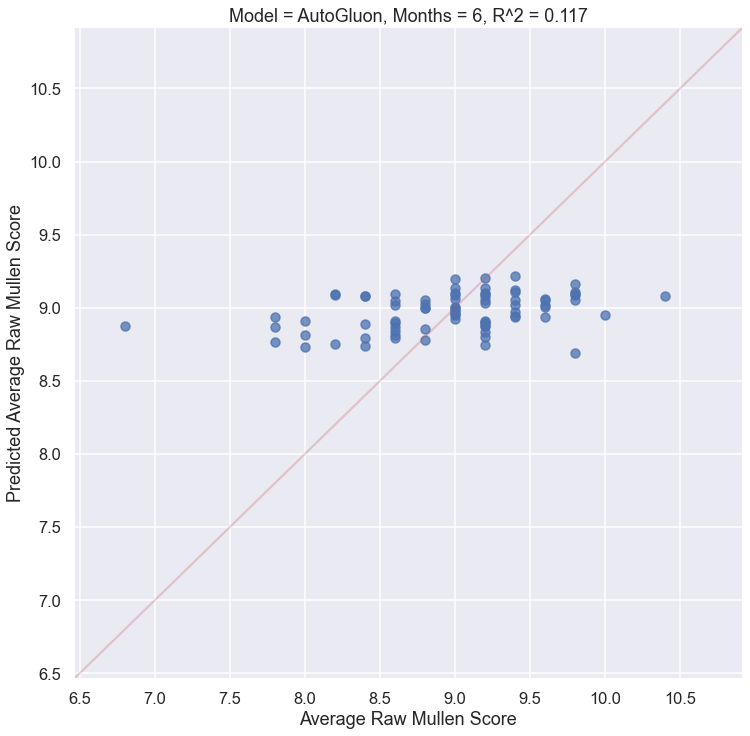

In [2]:
# plot scatter plots for 6m models
for model_name, results in raw_6m_results.items():
    y_est = get_held_outpredictions(X_6m, results['estimator'], raw_6m_outer_cv)
    plot_scatter(y_6m_raw, y_est, 6, model_name)

C:\miniconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


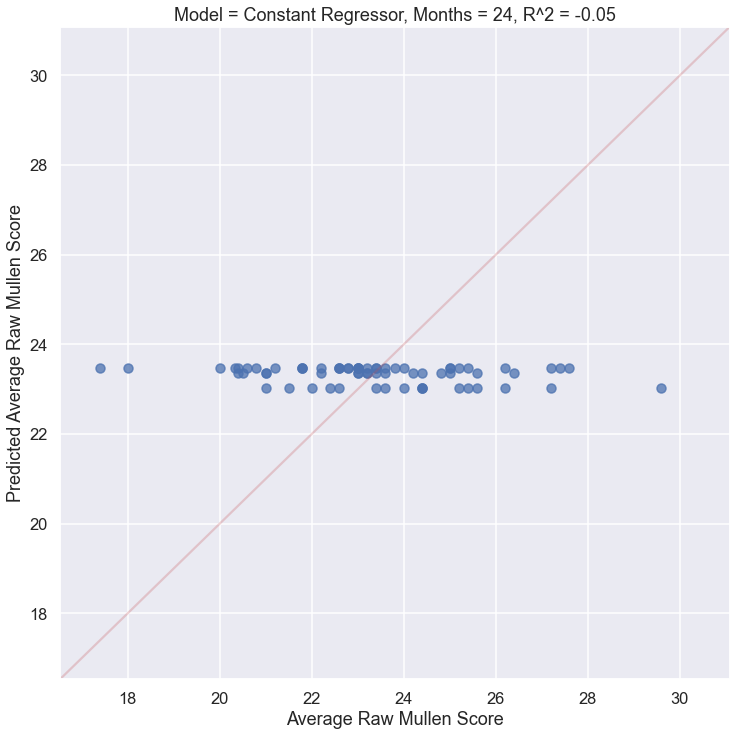

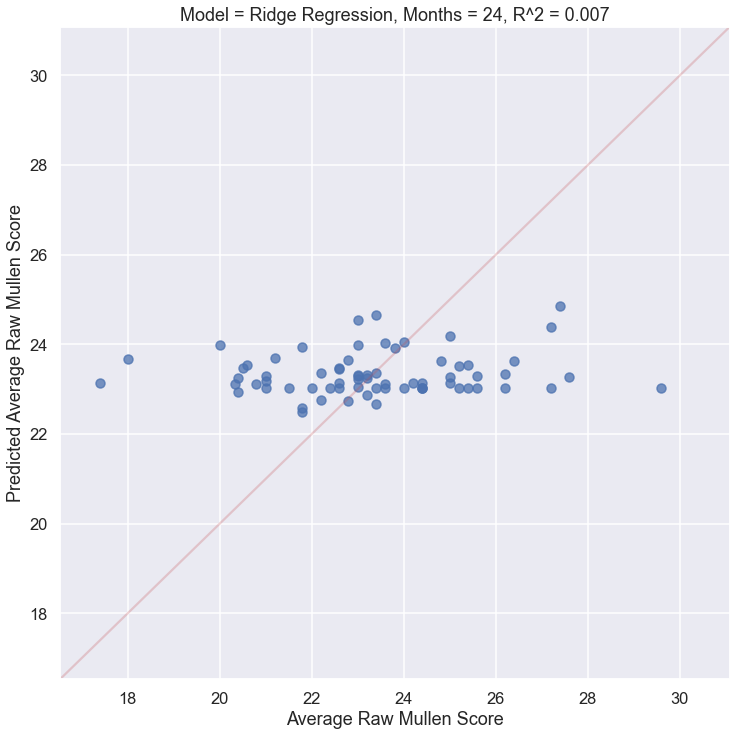

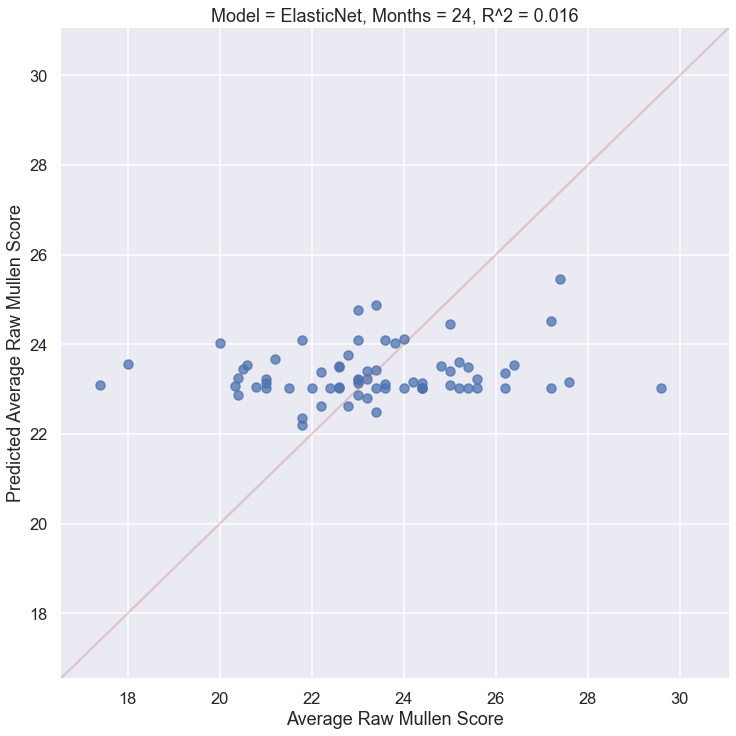

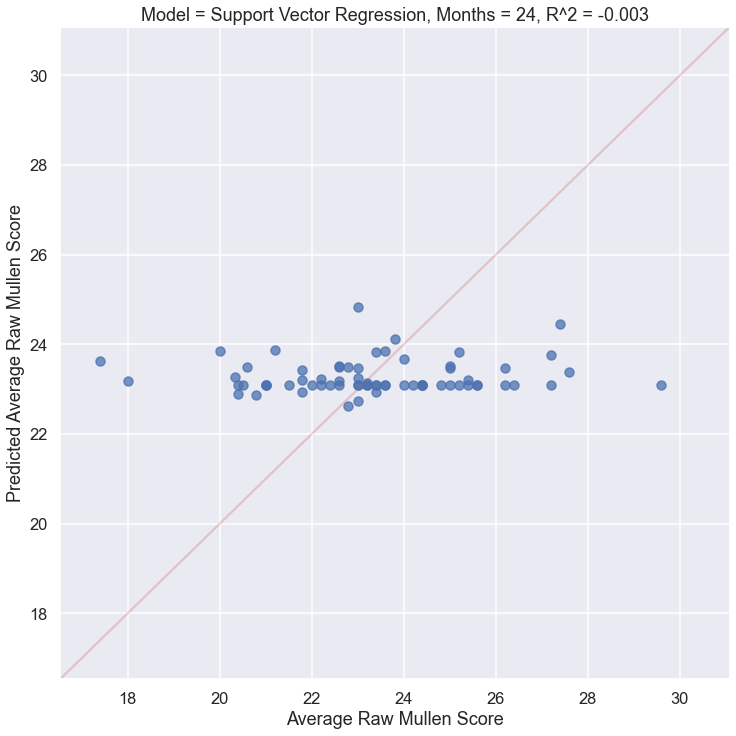

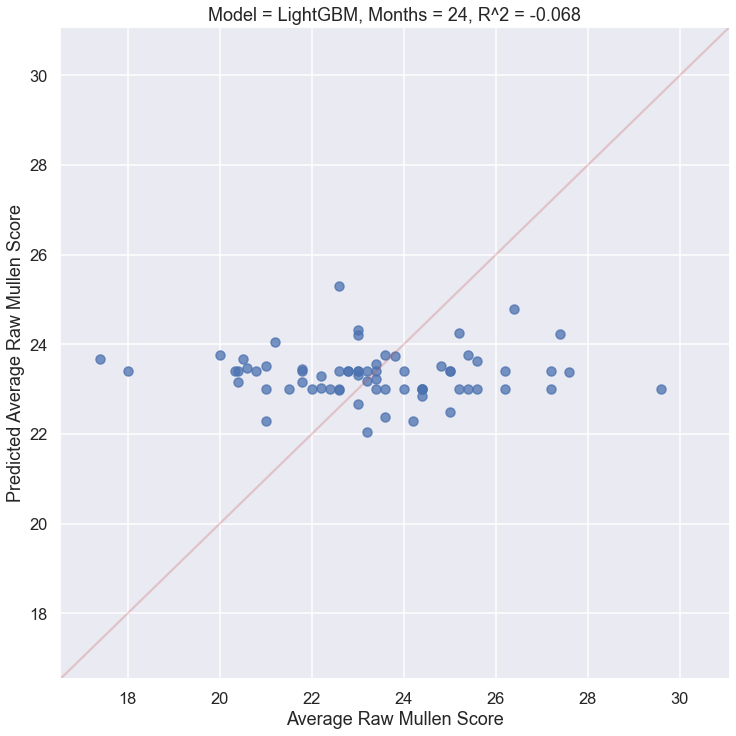

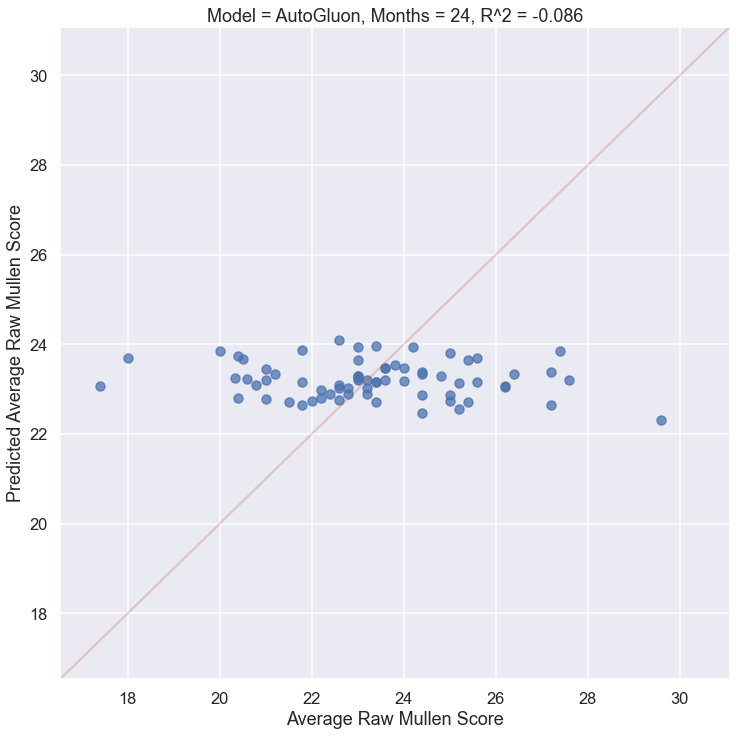

In [3]:
# plot scatter plots for 24m models
for model_name, results in raw_24m_results.items():
    y_est = get_held_outpredictions(X_24m, results['estimator'], raw_24m_outer_cv)
    plot_scatter(y_24m_raw, y_est, 24, model_name)